In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=16,family='serif')
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from multiprocessing import cpu_count, Pool
from corner import corner
from Cosmology import *
import sys

#Cosmological parameters
Omega_m = 0.3089
Omega_c = 0.6911

# Import data

## Supernova data

In [2]:
dataSN = np.loadtxt('jla_lcparams.txt', usecols=(2,4,6,8,10))
dataSN = dataSN[np.argsort(dataSN.T[0])]
errSN = np.loadtxt('jla_lcparams.txt', usecols=(5,7,9))[np.argsort(dataSN.T[0])]

#best fit values found in JLA analysis arXiv:1401.40664
a = 0.14
b = 3.14
MB = -19.04
delta_Mhost = -.06

In [3]:
SNdata = Supernova_data(dataSN, errSN, np.array([a,b,MB, 0]))

## Quasar data

In [4]:
dataQ = np.loadtxt('quasar_data_RL.txt', usecols=(0,1,2,3,4))
dataQ = dataQ[np.argsort(dataQ.T[0])]
errQ = np.loadtxt('quasar_data_RL.txt', usecols=5)[np.argsort(dataQ.T[0])]

#best fit values found in Risaliti & Lusso, Nature Astronomy, 2018
beta_prime, s = 7.4, 1.5

In [5]:
Qdata = Quasar_data(dataQ, errQ, np.array([beta_prime, s]))

# Set up and run the MCMC sampler [arXiv:1202.3665]

## Define the likelihood and priors

In [6]:
def lnlike(theta, SNdata, Qdata):
    Omegam, Omegac, a, b, MB, delta_Mhost, beta_prime, s = theta
    
    wLCDM = cosmology(Omegam, Omegac)
    log_prob = wLCDM.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
    log_prob += wLCDM.log_likelihood(Qdata.distance_modulus(), Qdata.delta_distance_modulus())
    
    if np.isnan(log_prob):
        return -np.inf
    else:
        return log_prob


def lnprior(theta):
    Omegam, Omegac, a, b, MB, delta_Mhost, beta_prime, s = theta
    #flat priors:
    if 0 < Omegam < 1.0 and 0 < Omegac < 1.0 and -5 <= a < 5 and -10 < b < 10 and -25 < MB < 0 and -0.5 < delta_Mhost < 0.5 and 0 < s <= 3:
        return 0.0
    return -np.inf

def lnprob(theta, SNdata, Qdata):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, SNdata, Qdata)

## set up and run the MC sampler locally...

In [7]:
ndim, nwalkers, nsteps = 8, 16, 100
pos0 = [np.array([Omega_m, Omega_c, a, b, MB, 0, beta_prime, s]) + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #, .2, 2, .1, -20]])
labs=[r'$\Omega_m$', r'$\Omega_\Lambda$', r'$\alpha$', r'$\beta$', r'$M_B$', r'$\Delta M_B$', r'$\beta^\prime$', r'$\delta$']

pool = Pool(cpu_count())
write = HDFBackend('results/LCDM_' + str(nwalkers) + 'x' + str(nsteps) + '.h5')
sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(SNdata, Qdata), pool=pool, backend=write)

In [67]:
index = 0
autocorr = np.empty(nsteps)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to nsteps steps
for i, sample in enumerate(sampler.sample(pos0, iterations=nsteps, progress=True)):
    # Only check convergence every 100 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.1)
    if converged:
        break
    old_tau = tau
pool.close()

100%|██████████| 100/100 [15:19<00:00,  9.15s/it]


## ...or load an existing chain from the cluser script

In [8]:
load_sampler = HDFBackend('results/LCDM_250x500.h5', read_only=True)

nsteps, nwalkers, ndim = load_sampler.get_chain().shape

# Check and visualise the convergence: $\tau_f / n_\mathrm{steps} < 1/100$

In [19]:
import emcee
emcee.autocorr.integrated_time?

In [40]:
[np.mean(emcee.autocorr.integrated_time(load_sampler.get_chain()[:i], tol=0))/i*50  for i in np.arange(10,400,10)]

/Users/moritz/anaconda3/envs/emcee3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/moritz/anaconda3/envs/emcee3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/Users/moritz/anaconda3/envs/emcee3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


[nan,
 4.827881052261604,
 5.045547234147223,
 4.909902614673659,
 5.145693167411412,
 5.157926844927572,
 5.148280764666568,
 5.135228690330522,
 5.064867701380631,
 4.978008034787923,
 4.948215861891032,
 4.879273608883216,
 4.8973471794229395,
 4.889438258200416,
 4.902959813816683,
 4.933418196827408,
 4.918815186897858,
 4.921194434599943,
 4.922164562189826,
 4.909201299606592,
 4.889138337874296,
 4.851192747681048,
 4.845090586159994,
 4.813291645363523,
 4.793203809863164,
 4.770919263705834,
 4.746941938749152,
 4.727937023569599,
 4.691864842022859,
 4.655273190217062,
 4.63155307432316,
 4.589503756009881,
 4.558076539209019,
 4.515528210687246,
 4.468938399526637,
 4.427441965491843,
 4.384748270018985,
 4.342369529785244,
 4.302009964331028]

In [34]:
[np.mean(emcee.autocorr.integrated_time(load_sampler.get_chain()[:i], tol=0)) for i in np.linspace(50,400,25)]

TypeError: slice indices must be integers or None or have an __index__ method

<IPython.core.display.Javascript object>


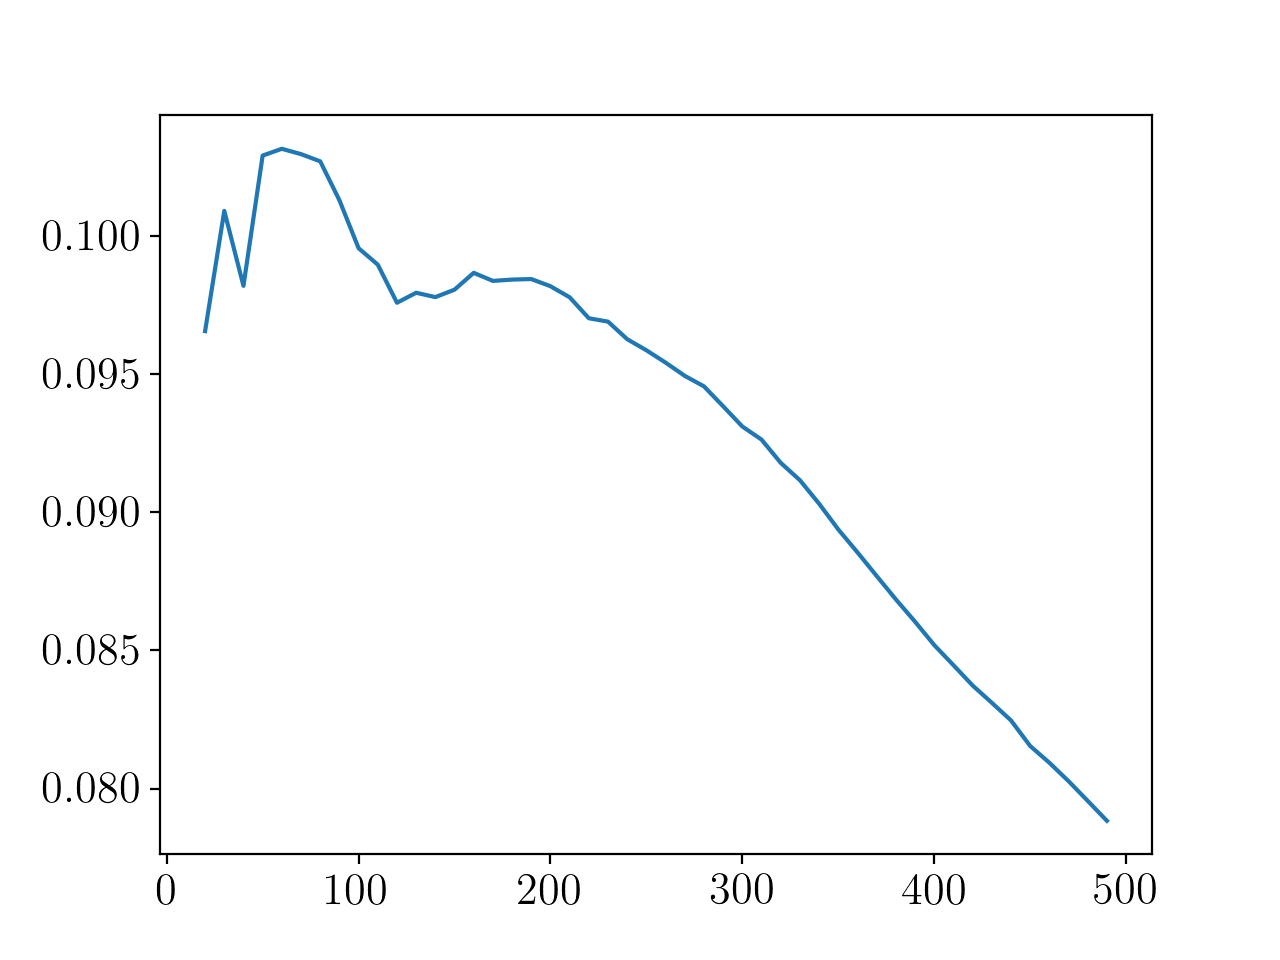

In [48]:
plt.figure()

plt.plot(np.arange(10,500,10), [np.mean(emcee.autocorr.integrated_time(load_sampler.get_chain()[:i], tol=0))/i  for i in np.arange(10,500,10)])

In [15]:
Nmin = 0
while np.mean(load_sampler.get_autocorr_time(tol=0,discard=Nmin))/(nsteps+Nmin)*50 > 1:
    Nmin+=25
    print(np.mean(load_sampler.get_autocorr_time(tol=0,discard=Nmin))/(nsteps+Nmin)*50)
    
print('Nmin = {}'.format(Nmin))

3.6127408213909558
3.3262702684087557
2.9098415094325687
2.5627363377068635
2.286793635973025
2.0620135542322844
1.875981868513412
1.6946068243641401
1.5348586685273482
1.3758710121620301
1.2268618205669612
1.0785865154534962
0.9384751768797825
Nmin = 325


<IPython.core.display.Javascript object>


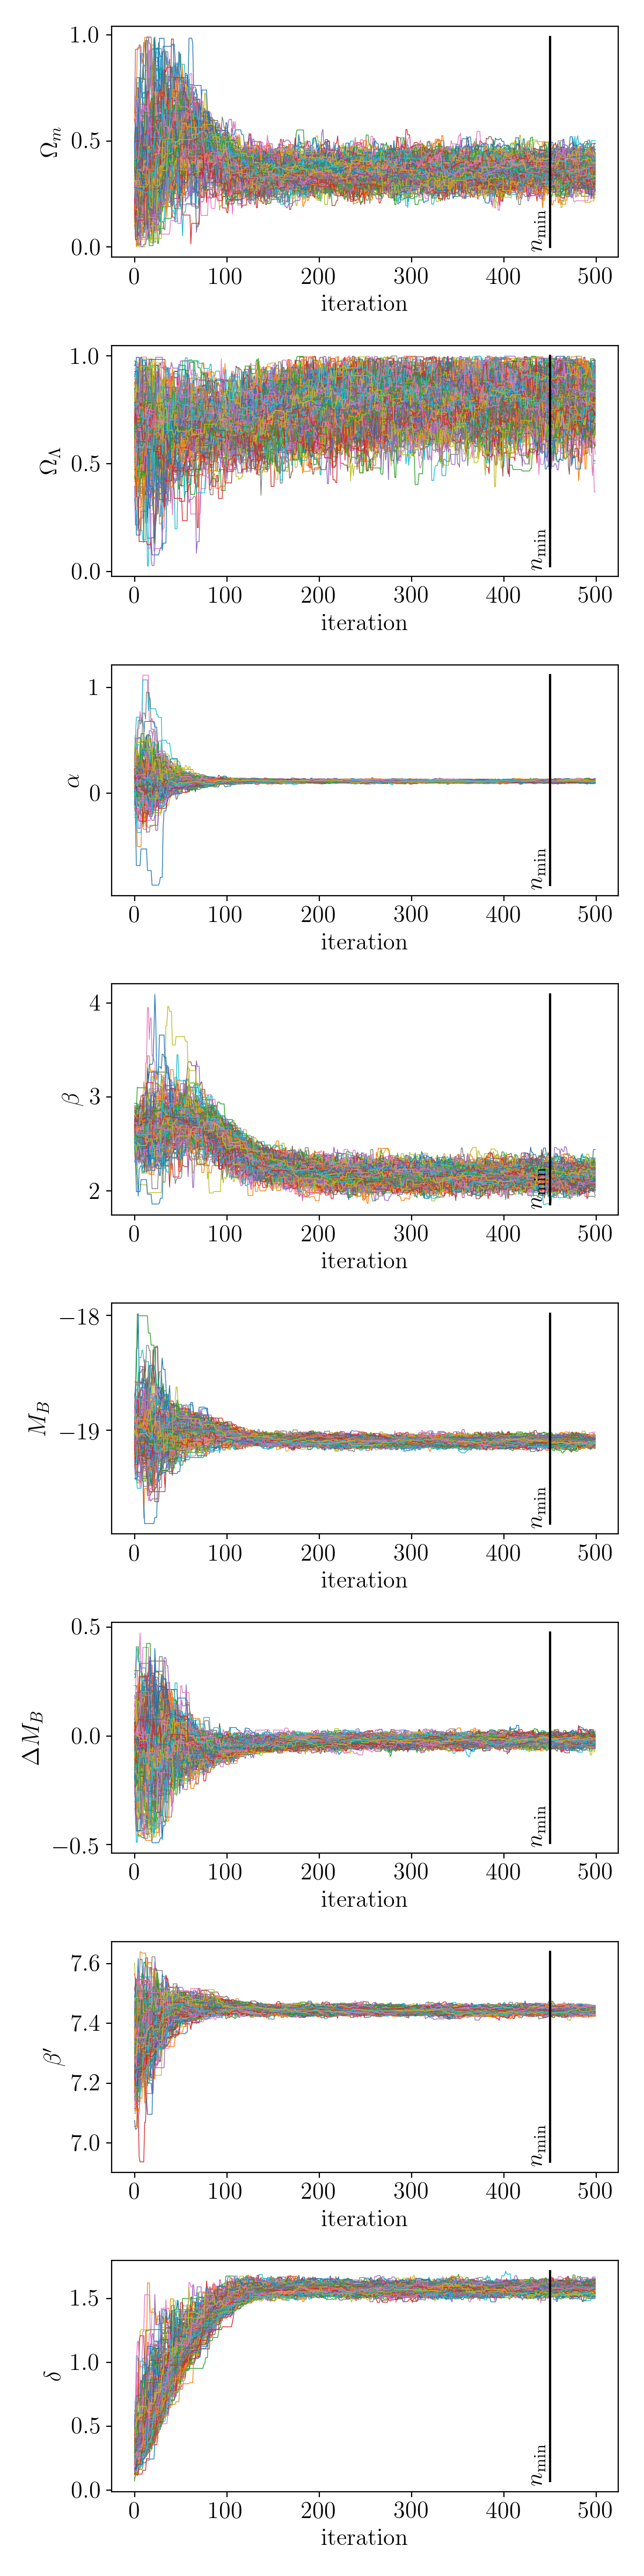

In [10]:
samples = load_sampler.get_chain()

f, ax = plt.subplots(len(samples.T), 1, figsize=(6,3*len(samples.T)))

for i in range(len(samples.T)):
    ax[i].plot(samples.T[i].T, lw=0.5)
    ax[i].plot([Nmin, Nmin], [min(samples.T[i].flatten()), max(samples.T[i].flatten())], c='k', lw=1.5)
    ax[i].text(Nmin, min(samples.T[i].flatten()), r'$n_\mathrm{min}$', rotation=90, ha='right')
    ax[i].set_ylabel(labs[i])
    ax[i].set_xlabel('iteration')
    
    
plt.tight_layout()
plt.show()

# Plot the posterior

<IPython.core.display.Javascript object>


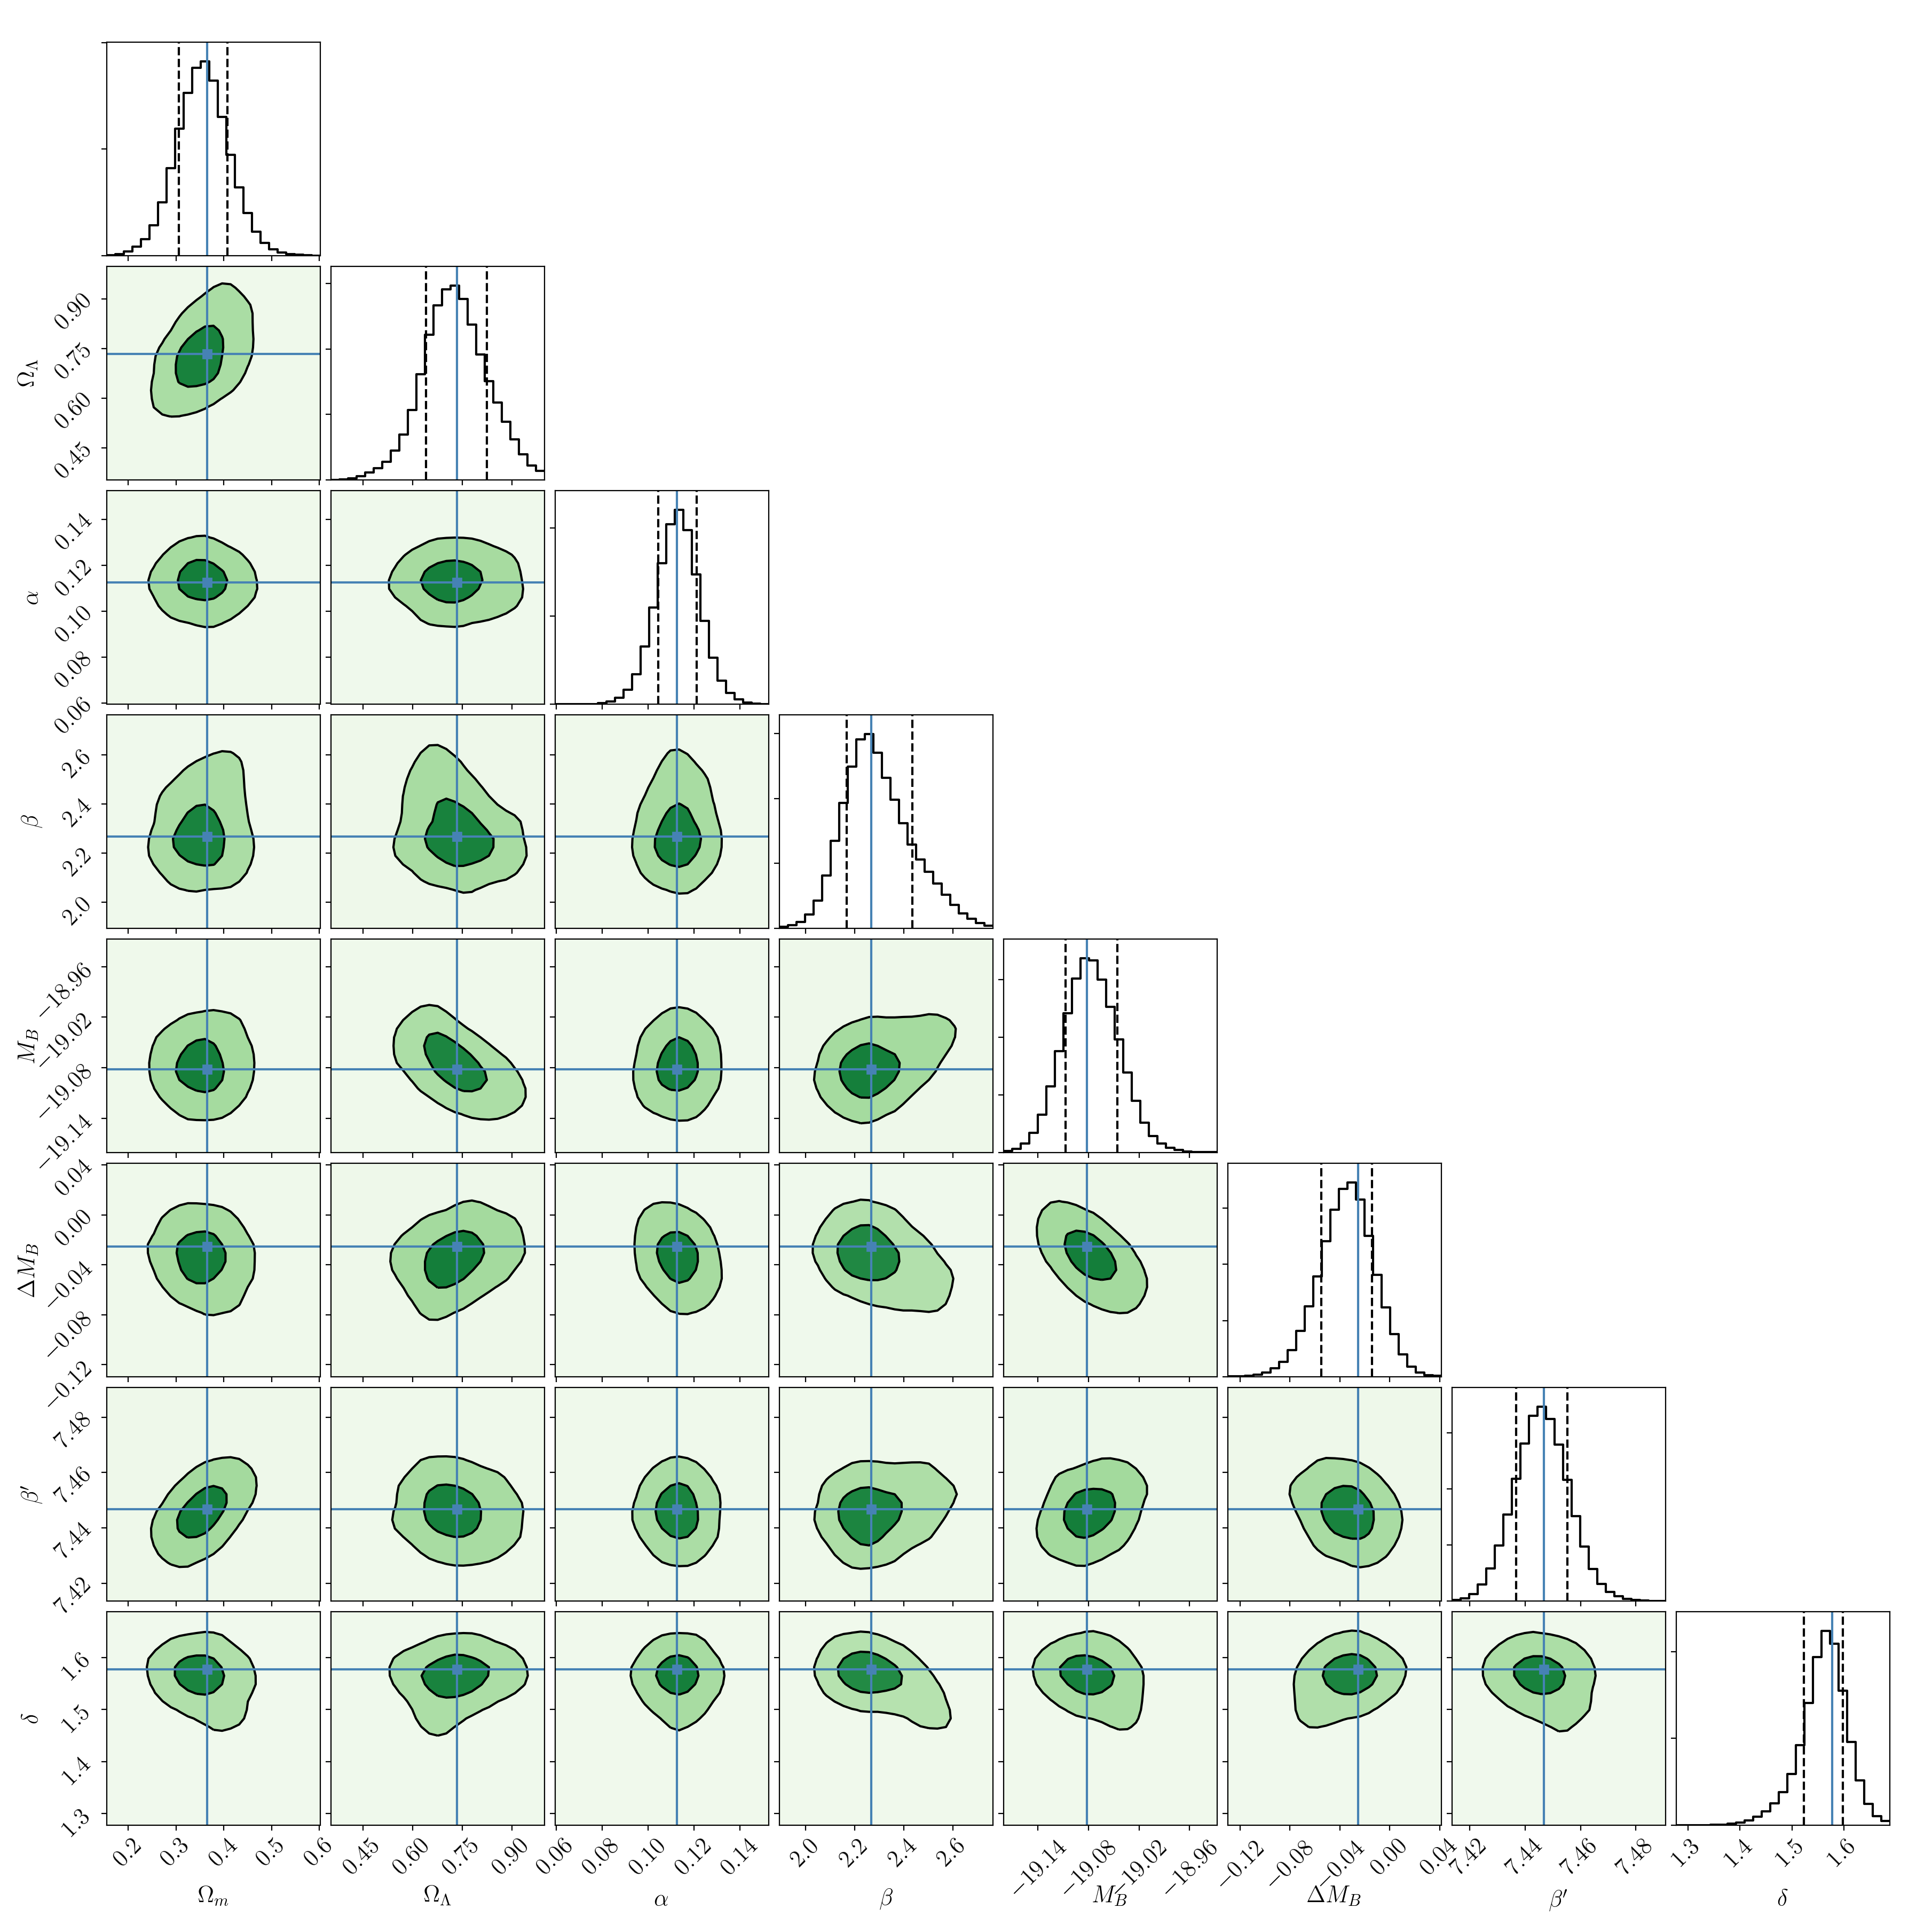

In [129]:
samples = load_sampler.get_chain()[Nmin:, :, :].reshape((-1, ndim))


meanLCDM = np.mean(samples, axis=0)
stdLCDM = np.var(samples, axis=0)
maxLCDM=[]
for i in range(len(meanLCDM)):
    likelihood = np.histogram(samples.T[i], bins=50)
    i_max=np.argmax(likelihood[0])
    max_val = (likelihood[1][i_max]+likelihood[1][i_max+1])/2
    maxLCDM.append(max_val)


fig = corner(samples, quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)),
             labels=labs, smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'),
             truths=maxLCDM)